# Linear Regression

In linear regression we try to fit a straight line to our test data, so our hypothesis is on the form $h_{\theta}(x) = \theta_{0} + \theta_{1}x$ for some parameters $\theta$ and data $x$.  
By convention $x_{0} = 1$, so our hypothesis can also be written as $h_{\theta}(x) = \theta^{T}x$.

In [1]:
import matplotlib.pyplot as plt # 2d plots
from mpl_toolkits.mplot3d import Axes3D # 3dplots
import numpy as np # matrices and numerical methods

%matplotlib inline

In [2]:
def warmupExercise():
    return np.eye(5)

In [3]:
warmupExercise()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.]])

Since linear regression is supervised learning, we have the expected output of any input, so our data looks like this (for features $x$ and expected outputs $y$).

$$
data =
\begin{bmatrix}
    x_{11} & \dots & x_{1n} & y_{1} \\
    \vdots & \ddots & \vdots & \vdots  \\
    x_{m1} & \dots & x_{mn} & y_{m}
\end{bmatrix}
$$
where  
$m = \text{number of examples}$  
$n = \text{number of features}$

We split these into two matrices, where $X \in \mathbb{R^{m \times n}, \hspace{2 mm} y \in \mathbb{R^{m}}}$ 

$$
X
=
\begin{bmatrix}
    x_{11} & \dots & x_{1n} \\
    \vdots & \ddots & \vdots  \\
    x_{m1} & \dots & x_{mn}
\end{bmatrix}
\hspace{10mm}\text{and}\hspace{10 mm}
y = 
\begin{bmatrix} 
    y_{1} \\
    \vdots \\
    y_{m}
\end{bmatrix}
$$

Likewise, our parameters $\theta \in \mathbb{R^{m}}$ is a column vector the size of our number of features, where we for convinience sake have added $\theta_{0} = 0$.

$$
\theta = 
\begin{bmatrix} 
    \theta_{1} \\
    \vdots \\
    \theta_{n}
\end{bmatrix}
\rightarrow
\begin{bmatrix} 
    \theta_{0} \\
    \theta_{1} \\
    \vdots \\
    \theta_{n}
\end{bmatrix}
$$

In [4]:
data = np.loadtxt('datasets/ex1data1.txt', delimiter=',')
X = np.c_[data[:,0]] # in the univariate case we only have 1 input
y = np.c_[data[:,1]] # expected outputs

We plot our data:

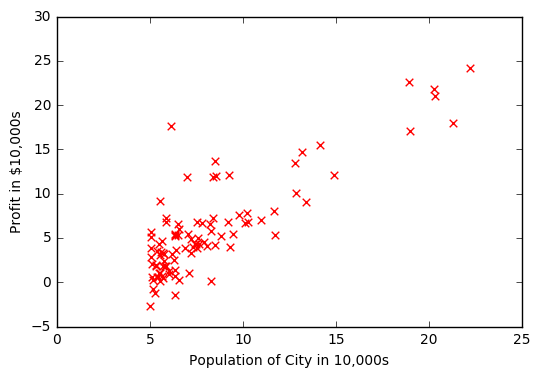

In [5]:
plt.scatter(X, y, s=30, c='r', marker='x', linewidths=1)
plt.xlim(0, 25)
plt.xlabel('Population of City in 10,000s')
plt.ylabel('Profit in $10,000s');

We add an _intercept term_ to our matrix of example data to simplify some of the math later on. (like how $x_{0} = 1$ earlier).

\begin{equation*}
X=
\begin{bmatrix}
    x_{11} & \dots & x_{1n} \\
    \vdots & \ddots & \vdots  \\
    x_{m1} & \dots & x_{mn}
\end{bmatrix}
  \rightarrow\begin{bmatrix}
    1 & x_{11} & \dots & x_{1n} \\
    \vdots & \vdots & \ddots & \vdots \\
    1 & x_{m1} & \dots & x_{mn}
\end{bmatrix}
\end{equation*}

In [6]:
# Add intercept term (a column of 1's to the left of the matrix)
X = np.insert(X, 0, 1, axis=1)

## The Cost Function / Optimization Objective

The cost function $J(\theta)$ is the average of the squared errors:

$$
J(\theta) = \frac{1}{2}\frac{1}{m}\sum_{i=1}^{m}({h_{\theta}(x^{(i)})} - y^{(i)})^{2}
$$

where  
$x^{(i)} = \text{i'th training example (a vector of features)} \in \mathbb{R^{n}}$  
$y^{(i)} = \text{i'th expected output} \in \mathbb{R}$  
$\theta = \text{a vector of parameters} \in \mathbb{R^{n}}$  

Less formally, this cost function measures how good we are to guessing correctly. A higher value means we're off by a large margin, and a smaller value means we're getting better at guessing.

Here we halved the average, this is to simplify some of the math later on, but since we're still trying to minimize, it does not make a difference.

In [7]:
# this is a naive implementation for the univariate case
def computeCost_naive(X, y, theta):
    m = X.shape[0] # number of examples
    n = X.shape[1] # number of features
    
    cost = 0
    for i in range(m): # iterate over all examples
        # the values are stored in arrays, we need to grab them
        Xval = X[i, 1]
        yval = y[i][0]
        theta0 = theta[0][0]
        theta1 = theta[1][0]
        
        # calculate the cost for each example and accumulate
        hyp = theta0 + theta1 * Xval
        error = hyp - yval
        cost += error * error;
        
    return (1 / (2 * m)) * cost

This implementation can be vectorized, so that we use matrix operations instead of loops, significantly speeding up the calculations, especially for large datasets.  

A vectorized approach also has the benefit of working in the multivariate case (where we try to predict using more features).

__note:__ the small convieniences we added to our parameters ($\theta_{0} = 0$), and examples $X$ (_adding the intercept term_), makes the implementation of the vectorized approach straight forward.

In [8]:
# this is a vectorized implementation, also works for multivarite
def computeCost(X, y, theta):
    m = X.shape[0] # number of examples
    
    predictions = X.dot(theta)
    errors = predictions - y
    sq_errors = np.square(errors)
    sum_of_sq_errors = np.sum(sq_errors)
    
    return (1/(2*m)) * sum_of_sq_errors

In [9]:
# note: we're using a placeholder for theta here, not a trained hyp.
computeCost_naive(X, y, [[0],[0]])

32.072733877455654

In [10]:
computeCost(X, y, [[0],[0]])

32.072733877455676

__From this point forward we will be using vectorized implementations, since they're more concise and also work for the multiple features.__

## Gradient Descent

Here we try to minimize our cost funtion $J(\theta)$, to get the best possible parameters $\theta$ to use for prediction, this is also know as the training-step.

$$
\underset{\theta}{\text{min}} \hspace{2 mm} J(\theta)
$$

We start out with some values for the parameters $\theta$, and during iterations of gradient descent (the minimization process), we try to improve them bit by bit.

More formally, the algorithm looks like this:

$$
\text{repeat until convergance \{} \\
\theta_{j} := \theta_{j} - \alpha \cdot \frac{\delta}{\delta \theta_{j}} J(\theta) \hspace{20 mm} \text{for all j, simultaneously} \\
\text{\}}
$$

$\alpha$ is the learning-rate, and determines how much we update our parameters with each iteration, have it too small, and the algorithm will run slowly, have it too large, and the algorithm may not converge.

We're using the partial derivitives of the cost function because they describe the slope, and we want to follow the slope down until we get to the optimal parameters (when the slope makes a horizontal line).

For each iteration we update the parameters $\theta$:

$$
\theta_{j} := \theta_{j} - \alpha \cdot \frac{\delta}{\delta \theta_{j}} J(\theta) \hspace{10mm} \text{for all j, simultaneously}
$$

The partial derivitive:

$$
\frac{\delta}{\delta \theta_{j}} J(\theta) = \frac{1}{m} \sum_{i=1}^{m}({h_{\theta}(x^{(i)})} - y^{(i)})x^{(i)}
$$

This is also knows as _batch gradient descent_ since we look at all $m$ examples for each iteration.

In [11]:
theta = [[0],[0]] # the parameters for our hypothesis
alpha = 0.01 # our learning rate for gradient descent
iterations = 1500 # how many iterations we're running gradient descent

In [12]:
# this is a vectorized implementation, also works for multivariate
def gradientDescent(X, y, theta, alpha, iterations):
    m = np.size(X, 0)
    J_hist = np.zeros(iterations)

    for i in np.arange(iterations):
        predictions = X.dot(theta)
        errors = predictions - y
        
        par_deriv = (1/m) * (X.T.dot(errors))
        theta = theta - alpha * par_deriv
        
        J_hist[i] = computeCost(X, y, theta)
    
    return (theta, J_hist)

In [13]:
theta, cost = gradientDescent(X, y, theta, alpha, iterations)
print('theta: ', theta.ravel())

theta:  [-3.63029144  1.16636235]


Our gradient descent implementation also gives a history of how the cost developed over its iterations, we can plot this history and check that it is descending, which means the error-rate it going down, and we're getting better.

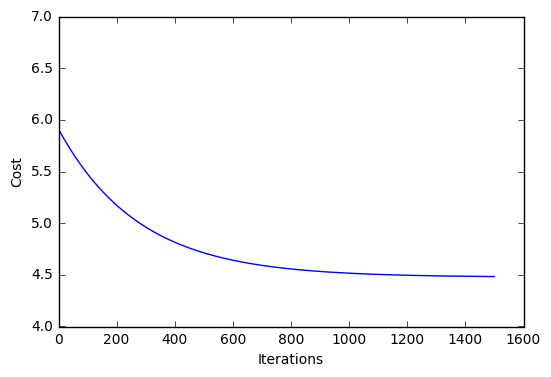

In [14]:
plt.plot(cost)
plt.ylabel('Cost')
plt.xlabel('Iterations');

Now we can plot our hypothesis $\theta$, and check how well it fits our data.

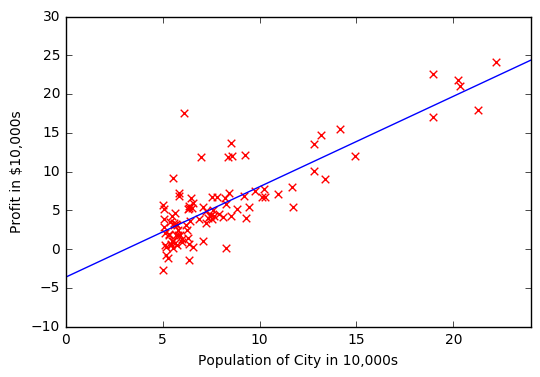

In [15]:
xs = np.arange(0,25) # we want to check for values 0...24
ys = theta[0] + theta[1] * xs # our predictions

plt.scatter(X[:,1], y, s=30, c='r', marker='x', linewidths=1)
plt.plot(xs, ys, label='test')

plt.xlim(0,24)
plt.xlabel('Population of City in 10,000s')
plt.ylabel('Profit in $10,000s');

In [16]:
print('For population = 35,000, we predict a profit of %f:' 
      % (theta.T.dot([1, 3.5]) * 10000))

print('For population = 70,000, we predict a profit of %f:' 
      % (theta.T.dot([1, 7]) * 10000))

For population = 35,000, we predict a profit of 4519.767868:
For population = 70,000, we predict a profit of 45342.450129:


To see how optimal our result is, we can check where our gradient descent ended up.

We do this by creating a contour plot of the value we got for our hypothesis $\theta$, and contour lines for our cost function $J(\theta)$ surrounding our hypothesis.

In [17]:
# create the values we need for plotting our gradient descent

theta0_axis = np.linspace(-10, 10, 100)
theta1_axis = np.linspace(-1, 4, 100)

xs, ys = np.meshgrid(theta0_axis, theta1_axis, indexing='xy')

J_vals = np.zeros((theta0_axis.size, theta1_axis.size))

# Calculate cost values
for (i,j),_ in np.ndenumerate(J_vals):
    J_vals[i,j] = computeCost(X, y, theta=[[xs[i,j]], [ys[i,j]]])

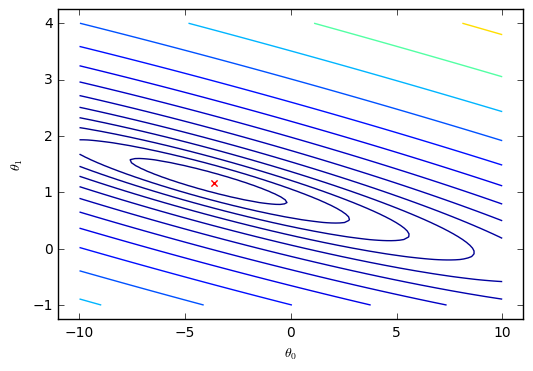

In [18]:
# create the coutour plot

plt.xlabel(r'$\theta_{0}$')
plt.ylabel(r'$\theta_{1}$');

plt.contour(xs, ys, J_vals, np.logspace(-2, 3, 30))
plt.scatter(theta[0], theta[1], c='r', marker="x");

Here we can see that we ended up in the middle of the optimum.

We can also visualize it in 3d:

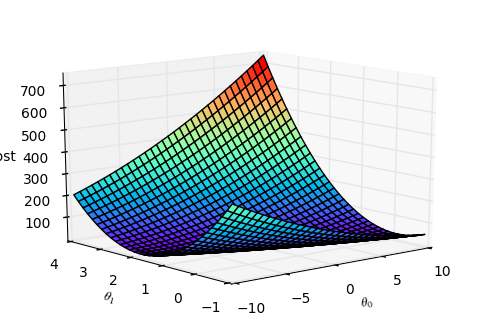

In [19]:
# create the 3d surface plot

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(xs, ys, J_vals, rstride=3, cstride=3, 
                cmap=plt.cm.rainbow)

ax.set_xlabel(r'$\theta_{0}$')
ax.set_ylabel(r'$\theta_{1}$')
ax.set_zlabel('Cost')

ax.set_zlim(J_vals.min(), J_vals.max())
ax.view_init(elev=15, azim=230)

# Multivariate Linear Regression

Using more features to predict outcomes gives a lot more power, since we have more information to base our estimations on.

In [20]:
data = np.loadtxt('datasets/ex1data2.txt', delimiter=',')
X = np.c_[data[:,0:2]]
y = np.c_[data[:,2]]

Now that we have more features, we need to think about their ranges.

Usually features have very different ranges (think number of bedrooms in a house (e.g. 3) vs. the price of the house (e.g. $300,000)).

Before using this data we want to normalize it to the same range (e.g. -0.5 to 0.5) so each feature has about the same 'weight'.

more formally, for each feature $x_{i}$ we replace it thus: 

$$ 
x_{i} := \frac{x_{i} - \mu_{i}}{s_{i}} 
$$
where  

$\mu_{i} = \text{the mean of all values in the feature}$  
$s_{i} = \text{the range of the values in the feature}$

This is also known as _mean normalization_.

__note:__ we mean normalize _before_ we add the intercept term to our data.

In [21]:
# note: we return the mean and standard deviation so we can normalize
# new test data we want to predict.
def normalizeFeatures(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    
    X_norm = X - mu
    X_norm = X_norm / sigma
    
    return (X_norm, mu, sigma)

In [22]:
X, mu, sigma = normalizeFeatures(X)
X = np.insert(X, 0, 1, axis=1) # add intercept term

To visualize how the learning rate $\alpha$ affects our result, we can plot some different experiments:

In [23]:
# try gradient descent with different values for alpha

theta, cost1 = gradientDescent(X, y, [[0],[0],[0]], 0.01, iterations)
theta, cost2 = gradientDescent(X, y, [[0],[0],[0]], 0.03, iterations)
theta, cost3 = gradientDescent(X, y, [[0],[0],[0]], 0.1, iterations)
theta, cost4 = gradientDescent(X, y, [[0],[0],[0]], 0.3, iterations)

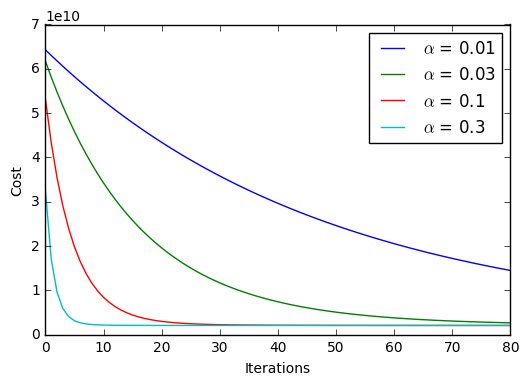

In [24]:
# plot the different results from out gradient descent runs

plt.plot(cost1, label=r'$\alpha$ = 0.01')
plt.plot(cost2, label=r'$\alpha$ = 0.03')
plt.plot(cost3, label=r'$\alpha$ = 0.1')
plt.plot(cost4, label=r'$\alpha$ = 0.3')

plt.xlim(0, 80)

plt.legend(loc='best')

plt.ylabel('Cost')
plt.xlabel('Iterations');

In this case we can see that we converge faster with a higher learning rate $\alpha$.

In [25]:
print("theta: " , theta.ravel())

theta:  [ 340412.65957447  109447.79646964   -6578.35485416]


To predict on new examples, we use the mean, $\mu$, and standard deviation, $\sigma^2$, to normalize the example first.

In [26]:
new_data = [1650, 3]
new_data = new_data - mu
new_data = new_data / sigma

# add intercept term
new_data = np.insert(new_data, 0, 1)

price = theta.T.dot(new_data)

print('Predicted price of a 1650 sq-ft, '
      '3 br house (using gradient descent): $%f' % price);

Predicted price of a 1650 sq-ft, 3 br house (using gradient descent): $293081.464335


For smaller datasets it is also possible to numerically solve for the best parameters $\theta$, instead of running gradient descent.

We do this by using the _normal equation_.

$$
\theta = (X^{T}X)^{-1}X^{T}y
$$

__note:__ We only do this for smaller datasets, because calculating the inverse of $X^{T}X$ quickly gets very expensive (if we have 100,000 examples, each with 100 features, this could take a long time).

__note:__ When we use this method we do not need to add intercept terms, or scale the features.

In [27]:
def normalEq(X, y):
    xtx = X.T.dot(X)
    pinvxtx = np.linalg.pinv(xtx)
    xty = X.T.dot(y)
    return pinvxtx.dot(xty)

In [28]:
data = np.loadtxt('datasets/ex1data2.txt', delimiter=',')
X = np.c_[data[:, 0:2]]
y = np.c_[data[:, 2]]

In [29]:
theta = normalEq(X, y)
print("theta: " , theta.ravel())

theta:  [   140.86108621  16978.19105903]


In [30]:
new_data = [1650, 3]
price = theta.T.dot(new_data)

print('Predicted price of a 1650 sq-ft, '
      '3 br house (using gradient descent): $%f' % price);

Predicted price of a 1650 sq-ft, 3 br house (using gradient descent): $283355.365425
